In [2]:
%matplotlib inline


# Cross Subject SSVEP



In [164]:
# Authors: Sylvain Chevallier <sylvain.chevallier@uvsq.fr>
#
# License: BSD (3-clause)

import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM

from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import SSVEPExo
from moabb.evaluations import CrossSubjectEvaluation,CrossSessionEvaluation,WithinSessionEvaluation
from moabb.paradigms import SSVEP, FilterBankSSVEP
from moabb.pipelines import SSVEP_CCA, ExtendedSSVEPSignal


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

## Loading dataset



In [142]:
dataset = SSVEPExo()
interval = dataset.interval
#dataset.subject_list = dataset.subject_list[:1]

In [143]:
print(dataset.subject_list)
print(interval)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2, 4]


In [144]:
records = dataset.get_data()

## Choose paradigm




In [145]:
paradigm_fb = FilterBankSSVEP(filters=None, n_classes=4)

2021-07-01 10:45:37,862 WARNING MainThread moabb.paradigms.ssvep Choosing the first 4 classes from all possible events


Classes are defined by the frequency of the stimulation, here we use
the first two frequencies of the dataset, 13 and 17 Hz.
The evaluation function uses a LabelEncoder, transforming them
to 0 and 1



In [146]:
freqs = paradigm_fb.used_events(dataset)
freqs

{'13': 2, '17': 3, '21': 4, 'rest': 1}

## Create pipelines



In [147]:
pipeline = {}

pipeline["MDM+scm"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="scm"),
    MDM()
)

pipeline["MDM+lwf"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="lwf"),
    MDM()
)

pipeline["TS+LogReg+scm"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="scm"),
    TangentSpace(),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)

pipeline["TS+LogReg+lwf"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="lwf"),
    TangentSpace(),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)
#pipelines = {}
#pipelines["CCA"] = make_pipeline(SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=3))

## Evaluation

The evaluation will return a dataframe containing a single AUC score for
each subject / session of the dataset, and for each pipeline.

Results are saved into the database, so that if you add a new pipeline, it
will not run again the evaluation unless a parameter has changed. Results can
be overwritten if necessary.



In [148]:
X, y, metadata = paradigm_fb.get_data(dataset)

In [149]:
X.shape

(960, 8, 513, 3)

In [150]:
def split(signal,n_session):
    n_sessions = signal.shape[0]//32
    trains_idx,tests_idx = [],[]
    for i in range(n_sessions):
        test_idx = list(range(i*32,(i+1)*32))
        train_idx=[]
        for j in range(signal.shape[0]):
            if not (j in test_idx):
                train_idx.append(j)
        trains_idx.append(train_idx)
        tests_idx.append(test_idx)
    return trains_idx,tests_idx


In [151]:
dictio={"rest":0,"13":1,"21":2,"17":3}
import numpy as np
y_= [dictio[y[l]] for l in range(len(y))]
y =np.asarray(y_)

In [152]:
print(len(y))

960


In [153]:
signals = []
labels=[]
n_sessions=[]
n = 0
for subject in dataset.subject_list :
    n_session = len(records[subject]['session_0'])
    n_sessions.append(n_session)
    m =32*n_session +n
    signals.append(X[n:m])
    labels.append(y[n:m])
    n=m

In [154]:
print(n_sessions)

[2, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 5]


In [155]:
print(len(labels[0]))

64


In [156]:
results = {"subject":[],"score":[],"train samples":[], "test samples":[], "pipeline":[]}
for k in pipeline.keys():
    clf= pipeline[k]
    for i in range(len(dataset.subject_list)):
        accs= []
        subject = dataset.subject_list[i]
        signal,n_session,label = signals[i],n_sessions[i],labels[i]
        trains_idx,tests_idx = split(signal,n_session)
        for train_idx,test_idx in zip(trains_idx,tests_idx):
            X_train,X_test = signal[train_idx],signal[test_idx]
            y_train,y_test = label[train_idx],label[test_idx]
            clf.fit(X_train,y_train)
            preds= clf.predict(X_test)
            acc = np.mean(preds==y_test)
            accs.append(acc)
        results["subject"].append(subject)
        results["score"].append(np.mean(accs))
        results["pipeline"].append(k)
        results["train samples"].append(len(train_idx))
        results["test samples"].append(len(test_idx))

Filter bank processing, determine automatically the filter from the
stimulation frequency values of events.



## Plot Results

Here we plot the results.



In [159]:
df = pd.DataFrame(results)
df

,subject,score,train samples,test samples,pipeline
0,1,0.437500,32,32,MDM+scm
1,2,0.578125,32,32,MDM+scm
2,3,0.843750,32,32,MDM+scm
3,4,0.625000,32,32,MDM+scm
4,5,0.484375,32,32,MDM+scm
5,6,0.609375,32,32,MDM+scm
6,7,0.645833,64,32,MDM+scm
7,8,0.640625,32,32,MDM+scm
8,9,0.375000,32,32,MDM+scm
9,10,0.468750,96,32,MDM+scm


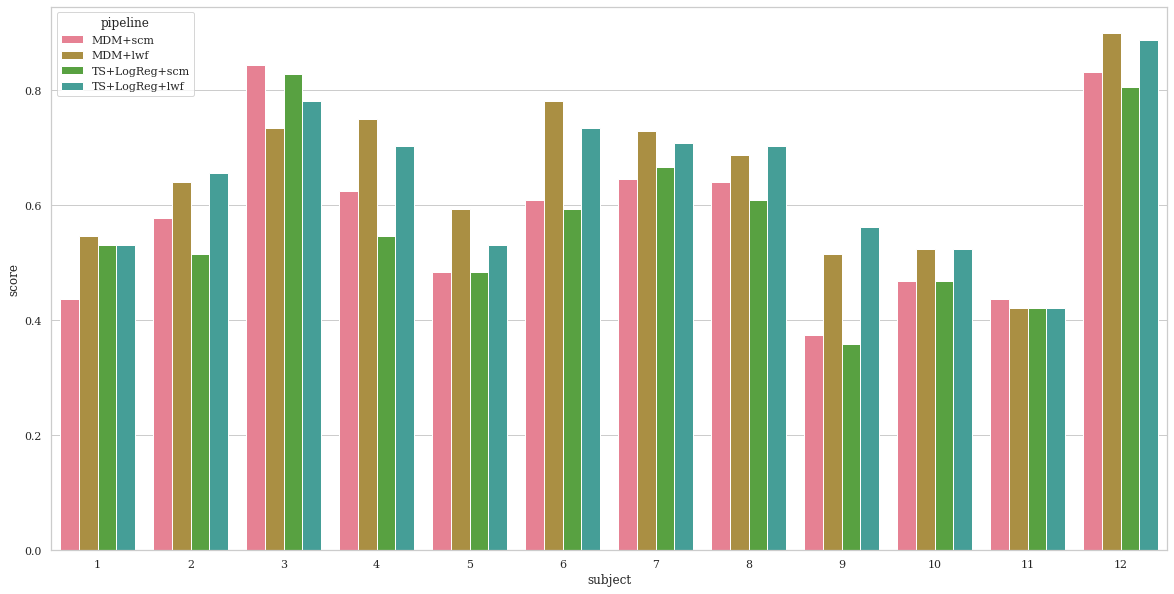

In [160]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, y="score", x="subject", hue="pipeline")

plt.show()

In [165]:
#cross_session

evaluation1 = WithinSessionEvaluation(
    paradigm=paradigm_fb, datasets=dataset, overwrite=True
)
results1 = evaluation1.process(pipeline)

results1

2021-07-01 14:37:50,701 INFO MainThread moabb.evaluations.base Processing dataset: SSVEP Exoskeleton
2021-07-01 14:37:57,007 INFO MainThread moabb.evaluations.base MDM+scm | SSVEP Exoskeleton | 1 | session_0: Score 0.562
2021-07-01 14:37:58,444 INFO MainThread moabb.evaluations.base MDM+lwf | SSVEP Exoskeleton | 1 | session_0: Score 0.610
2021-07-01 14:38:00,375 INFO MainThread moabb.evaluations.base TS+LogReg+scm | SSVEP Exoskeleton | 1 | session_0: Score 0.671
2021-07-01 14:38:01,791 INFO MainThread moabb.evaluations.base TS+LogReg+lwf | SSVEP Exoskeleton | 1 | session_0: Score 0.671
2021-07-01 14:38:05,563 INFO MainThread moabb.evaluations.base MDM+scm | SSVEP Exoskeleton | 2 | session_0: Score 0.688
2021-07-01 14:38:06,905 INFO MainThread moabb.evaluations.base MDM+lwf | SSVEP Exoskeleton | 2 | session_0: Score 0.701
2021-07-01 14:38:08,537 INFO MainThread moabb.evaluations.base TS+LogReg+scm | SSVEP Exoskeleton | 2 | session_0: Score 0.562
2021-07-01 14:38:09,894 INFO MainThread m

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.610256,0.283402,64.0,1,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
1,0.701282,0.262951,64.0,2,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
2,0.874359,0.274595,64.0,3,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
3,0.843590,0.285338,64.0,4,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
4,0.596154,0.275595,64.0,5,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
5,0.669231,0.265588,64.0,6,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
6,0.863684,0.378068,96.0,7,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
7,0.687180,0.276997,64.0,8,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
8,0.608974,0.352250,64.0,9,session_0,8,1,SSVEP Exoskeleton,MDM+lwf
9,0.609231,0.464930,128.0,10,session_0,8,1,SSVEP Exoskeleton,MDM+lwf


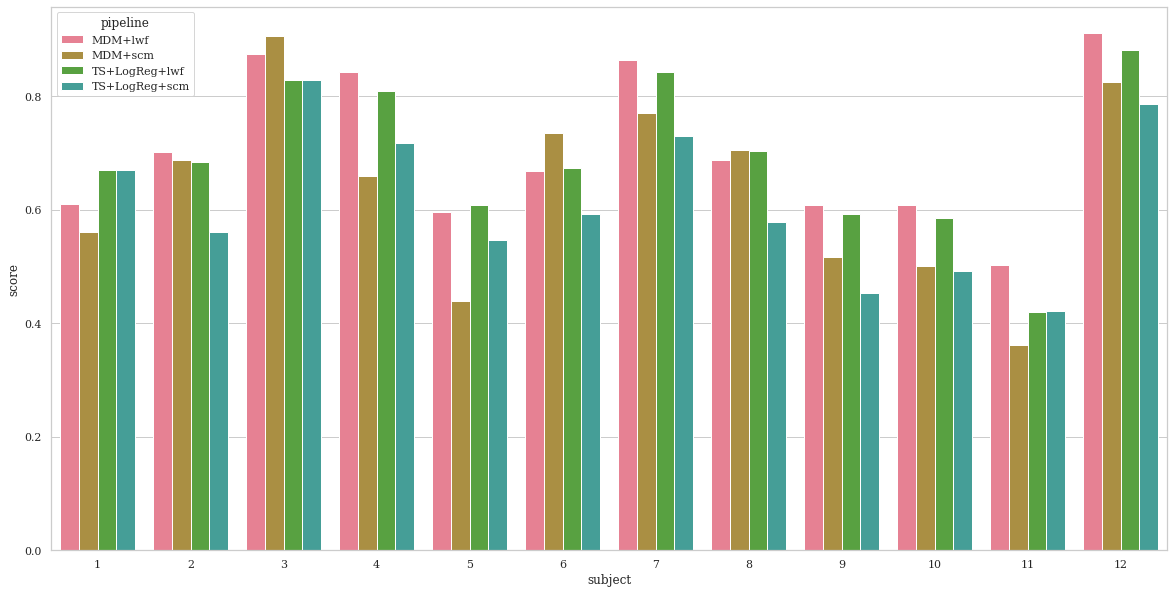

In [166]:
plt.figure(figsize=(20,10))
sns.barplot(data=results1, y="score", x="subject", hue="pipeline")

plt.show()